### TODO:
- [x] Ask Farbod if all ray-casted data (MSW + BMBF) is on the folder `MSW-BMBF data/Processed Raycast Data/`, inside the folders `CsvData MSW-Left` and `CsvData MSW-Right`
- [x] Ask about the meaning of the different hits `centerHit`, `centerHitGroup`, `boxHit`, `boxHitGroup`. Also, what is `presentObjectName` and `presentObjectGroup`
- [x] Best way (column) to check possible poor estimate of fixations? => `centerHitGroup` or `boxHitGroup`
- [x] FPS of the experiment (average)? -> last frame count (it should be 3070 if experiment finished) - first (400) / 90 (seconds). => Should be 29.6 FPS (~ 30 FPS)
- [x] Why the ray-casted CSV files sizes differ so much? Is it because unfinished experiments? => Yes, but mostly because the colliders values differ (text length on plain text files)
- [x] TAM scores. Do they come from each column or do they need to be calculated? So, `trust` column? => Direct scores, no need to calculate anything
- [x] Check Jasmine's presentation to know how to differentiate between saccades and fixations and apply it
- [x] Select all ray-casted data participants that answered the questionnaire
- [x] Find out why the participants count (colliders and questionnaires) differ from Farbod's notebook: https://github.com/farbod69/TAM-Data-Analyis/blob/master/Readme.md
- [x] Check if the `HitGroups` can be directly categorized between traffic-relevant and non-traffic-relevant
- [x] Take the preprocessed questionnaires, process them dropping the participants with missing trust values, remove duplicates
- [ ] Check NaNs properly on data_cleanup
- [ ] Remove examples that make no sense (e.g. age<10 and age>90)
- [ ] Plot the Trust variable, explore it like Age
- [x] Reorganize dataframe
- [x] Add multiprocessing while checking all participants
- [ ] Plot most fixated vs saccaded objects
- [ ] Plot Trust vs most-fixated objects/group (TR vs non-TR)

__Dependencies__

In [21]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [22]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.2f}".format

style = "darkgrid"
sns.set_style(style)  # set seaborn plotting style

# static plots
%matplotlib inline
# interactive plots
# %matplotlib widget

cores = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {cores}")

Total CPU threads: 12


__Read participants cleaned data__

In [23]:
parts = pd.read_csv("./data/participants.csv", keep_default_na=False)
parts = parts.set_index("uid")  # set uid column as index (remove default)
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


__Descriptive statistics from each numerical variable__

In [24]:
cols = list(parts.describe().columns.difference(["frames"]))
parts[cols].describe()

,Age,Aviophobia,Driving,Ease,Intention,Play,Trust,Usefulness
count,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00
mean,30.34,0.14,16.42,64.57,61.03,8.84,66.96,63.91
std,21.47,0.35,21.91,31.52,34.43,20.95,31.86,32.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,13.00,0.00,0.00,50.00,34.00,0.00,50.00,50.00
50%,21.00,0.00,6.00,70.00,66.00,1.00,75.00,70.00
75%,47.00,0.00,29.00,99.00,100.00,7.00,100.00,99.00
max,99.00,1.00,99.00,100.00,100.00,99.00,100.00,100.00


__Distribution of each numerical variable__

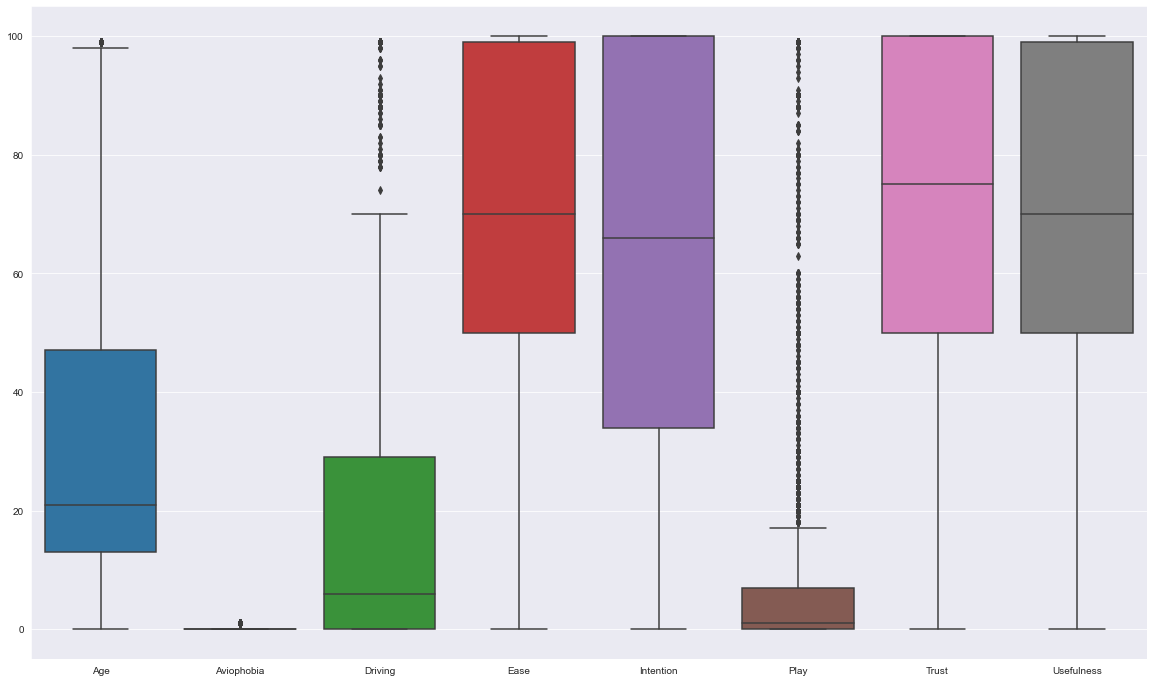

In [25]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=parts[parts.columns.difference(["frames"])], order=cols)
plt.show()

__Correlation matrix of the numerical variables__

,Age,Aviophobia,Driving,Ease,Intention,Play,Trust,Usefulness
Age,1.00,-0.01,0.64,-0.14,-0.14,-0.05,-0.12,-0.14
Aviophobia,-0.01,1.00,0.08,-0.08,-0.06,0.18,-0.10,-0.06
Driving,0.64,0.08,1.00,-0.08,-0.09,0.25,-0.10,-0.11
Ease,-0.14,-0.08,-0.08,1.00,0.60,0.05,0.50,0.55
Intention,-0.14,-0.06,-0.09,0.60,1.00,0.03,0.51,0.65
Play,-0.05,0.18,0.25,0.05,0.03,1.00,-0.06,0.02
Trust,-0.12,-0.10,-0.10,0.50,0.51,-0.06,1.00,0.47
Usefulness,-0.14,-0.06,-0.11,0.55,0.65,0.02,0.47,1.00


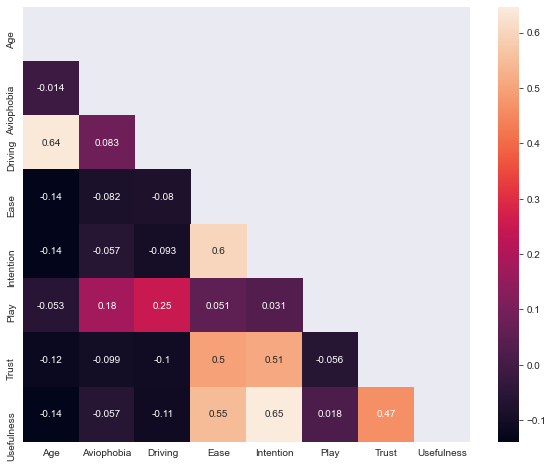

In [26]:
# remove the number of frames as it's uninformative
parts_an = copy.deepcopy(parts[parts.columns.difference(["frames"])])

cm_parts = parts_an.corr(method="pearson")
display(cm_parts)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(cm_parts, dtype=np.bool))

# figure size
plt.figure(figsize=(10, 8))

# display the correlation matrix as a heatmap
sns.heatmap(cm_parts, annot=True, mask=mask)
plt.show()

__Population count and density for each categorical variable__

,count,%
Gender,,
Male,4048,51.16
Female,3105,39.24
intersex,402,5.08
N/A,358,4.52


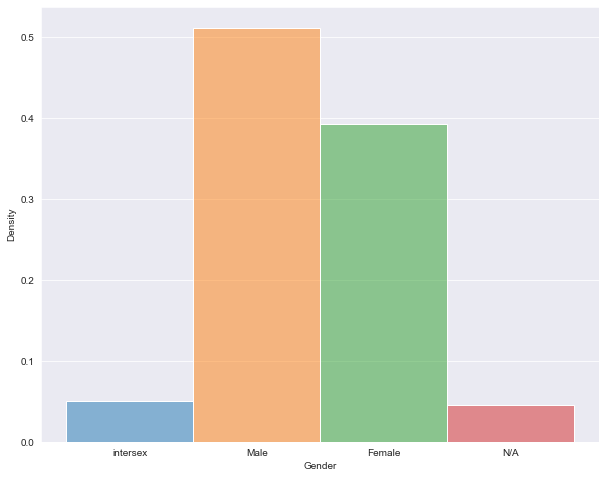

,count,%
VR,,
never,2676,33.82
less than 10 times,2517,31.81
once,1711,21.62
more than 10 times,1009,12.75


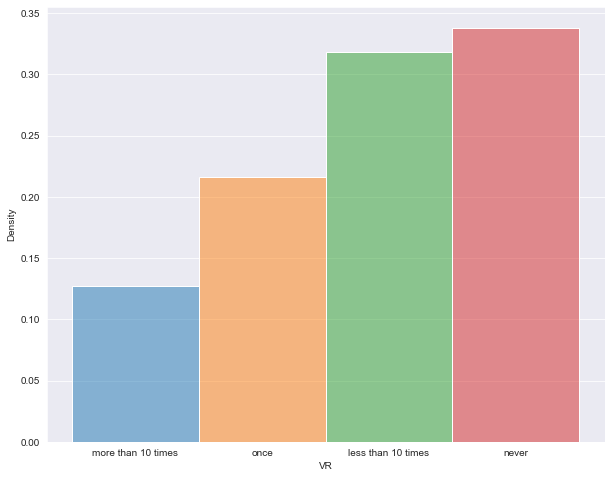

,count,%
expo,,
MSW,6763,85.47
BMBF,1150,14.53


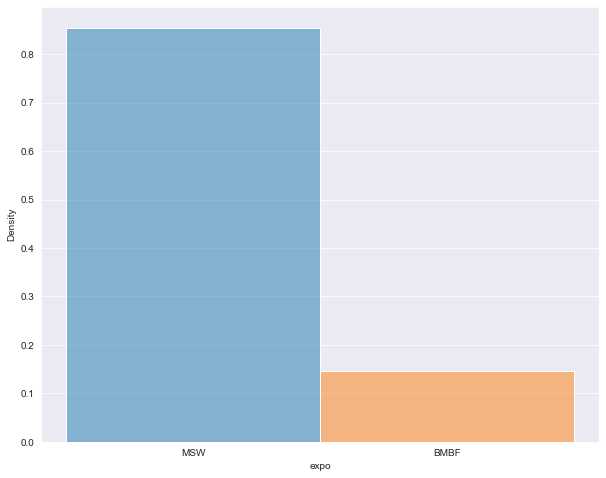

,count,%
condition,,
AVAS,3284,41.50
RadioTalk,3046,38.49
TaxiDriver,1583,20.01


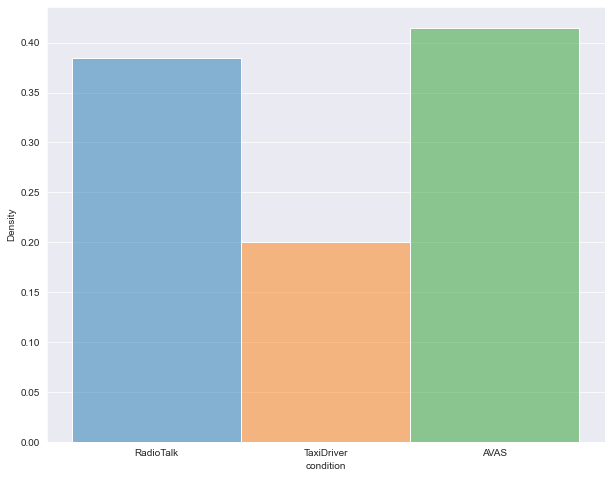

In [27]:
# categorical columns to compute descriptive statistics
cols = ["Gender", "VR", "expo", "condition"]
for col in cols:  # for each defined column
    counts = parts[col].value_counts()
    percents = parts[col].value_counts(normalize=True).mul(100)
    df = pd.DataFrame({"count": counts, "%": percents})
    df.index.name = col
    # show counts vs percentage
    display(df)
    # plot directly without the previous calculations (seaborn takes care of it)
    plt.figure(figsize=(10, 8))
    ax = sns.histplot(data=parts, x=col, hue=col, stat="density", legend=False)
    ax.grid(False, axis="x")
    plt.show()

__Age distribution__

,Age
count,7913.00
mean,30.34
std,21.47
min,0.00
25%,13.00
50%,21.00
75%,47.00
max,99.00
mode,12.00


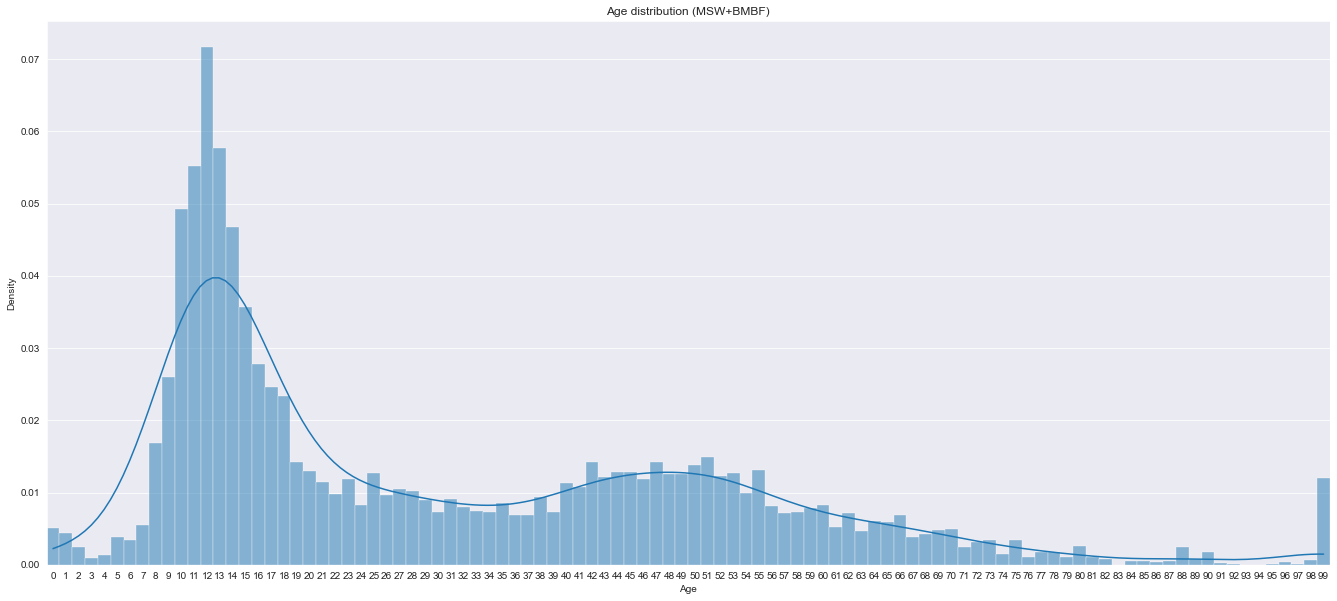

In [28]:
df_age = pd.DataFrame(parts.Age.describe())
df_age.loc["mode"] = parts.Age.mode()[0]
display(df_age)

ax = sns.histplot(
    data=parts,
    x="Age",
    kde=True,
    discrete=True,
    stat="density",
)
xticks = [a for a in range(100)]
ax.set(xticks=xticks, xticklabels=xticks)
ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Age distribution (MSW+BMBF)")
plt.gcf().set_size_inches(23, 10)
plt.show()

,%
Age,
12,7.17
13,5.78
11,5.52
10,4.93
14,4.68
...,...
96,0.04
91,0.03
92,0.01


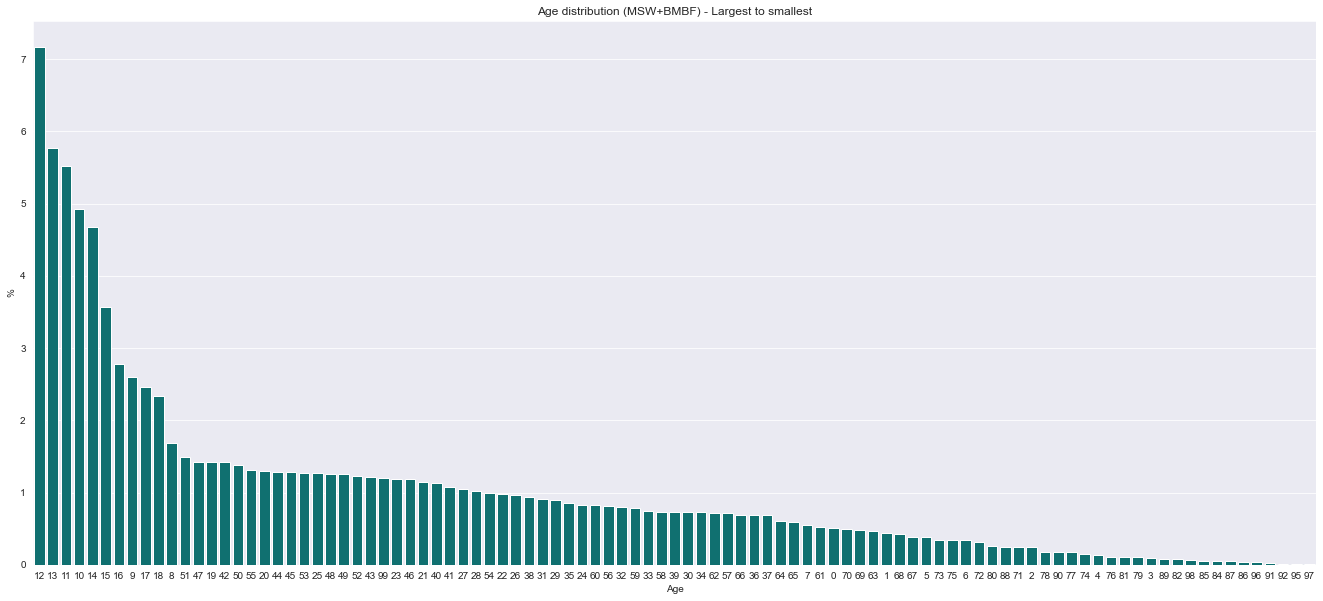

In [29]:
# normalize and get percentage
age_counts = parts.Age.value_counts(normalize=True).mul(100)
ages = age_counts.index.values

age_per = pd.DataFrame({"%": age_counts.values}, index=ages)
age_per.index.name = "Age"
display(age_per)

ax = sns.barplot(
    data=age_per, x=age_per.index, y="%", order=ages, color="teal"
)

ax.grid(False, axis="x")

plt.title("Age distribution (MSW+BMBF) - Largest to smallest")
plt.gcf().set_size_inches(23, 10)
plt.show()

__Gaze Definition__

Participants data

In [30]:
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


Select a participant to test Jasmine's Gaze definition (saccades and fixations differentiation)

In [31]:
# select first participant colliders file
file = parts.iloc[0].file  # get filename
part_col = pd.read_csv(f"./data/colliders/{file}", keep_default_na=False)

Get average framerate

In [32]:
first_frame = part_col.frameNumber.iloc[0]
last_frame = part_col.frameNumber.iloc[-1]

frame_diff = last_frame - first_frame
afps = frame_diff / 90
afps

29.666666666666668

Assuming constant framerate (sampling frequency, FPS), the sampling period (time distance between samples, in seconds)

In [33]:
asp = 1 / afps
asp

0.033707865168539325

From here on we follow this assumption. So we're going to use the latter average FPS (sampling frequency) and sampling period (1/SF).

In [14]:
# Every consecutive hitpoints between 0 and 100ms after
# a fixation/gaze (>=260-330ms) will be labeled as saccades
saccade_l = (0, 0.1)  # saccade length (<=100ms)
gaze_l = (0.26, 0.33)  # gaze length (min, max)

Given our SF/SP (≈29.67FPS/0.337s), how many hit points do we need to find a saccade and a gaze?

In [15]:
hp_saccade = 0.1 / asp
hp_saccade

2.966666666666667

A saccade shouldn't take at least 1-3 hit points

In [16]:
hp_gaze = (0.26 / asp, 0.33 / asp)
hp_gaze

(7.713333333333334, 9.790000000000001)

A gaze should at least have 7-10 hit points

Thus we will consider anything between 1 and 6 hitpoints a saccade and over 7 a gaze/fixation

__Distribution of hits__

Read processed hits data

In [17]:
# without index_col=0 (default None), generates an index instead of using the first column
hits_df = pd.read_csv("./data/consecutive_hits.csv", keep_default_na=False)
hits_df

,uid,hitType,0,1,2,3,4,5,6,7,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,center,833,45,15,8,9,12,2,4,...,0,0,0,0,0,0,0,0,0,0
1,ec61bab6e46741969bceb80ee2246983,box,690,66,25,14,15,11,8,11,...,0,0,0,0,0,0,0,0,0,0
2,1fbde03890d94bddaf7aa987fc732607,center,2527,15,7,0,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1fbde03890d94bddaf7aa987fc732607,box,1082,43,12,11,13,9,8,6,...,0,0,0,0,0,0,0,0,0,0
4,1ad9eea672a94518b150925bac41fcbc,center,601,62,31,13,12,9,2,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15821,2cd78ad9a37945de9f8cfd5f81c42082,box,536,62,43,28,16,18,13,12,...,0,0,0,0,0,0,0,0,0,0
15822,dba04b626e4c4c6e89aea4fb1f9cc32b,center,437,1,3,2,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0
15823,dba04b626e4c4c6e89aea4fb1f9cc32b,box,29,28,12,5,12,4,5,5,...,0,0,0,0,0,0,0,0,0,0
15824,18ffb0abdc8642098c479380bfa533d1,center,729,83,44,28,12,12,9,6,...,0,0,0,0,0,0,0,0,0,0


Calculate nulls vs rest

In [18]:
# all columns except for nulls counter (0), and hitType
cols = list(hits_df.describe().columns.difference(["hitType", "0"]))
hits_count = {"uid": [], "type": [], "nulls": [], "hits": []}
pbar = tqdm(iterable=hits_df.index.values)
for row in pbar:
    current = hits_df.loc[row]
    hits_count["uid"].append(current.uid)
    hits_count["type"].append(current.hitType)
    hits_count["nulls"].append(current["0"])
    total = sum([int(col) * current[col] for col in cols])
    hits_count["hits"].append(total)

hits_count = pd.DataFrame(hits_count)
display(hits_count)

  0%|          | 0/15826 [00:00<?, ?it/s]

,uid,type,nulls,hits
0,ec61bab6e46741969bceb80ee2246983,center,833,1838
1,ec61bab6e46741969bceb80ee2246983,box,690,1981
2,1fbde03890d94bddaf7aa987fc732607,center,2527,144
3,1fbde03890d94bddaf7aa987fc732607,box,1082,1589
4,1ad9eea672a94518b150925bac41fcbc,center,601,2070
...,...,...,...,...
15821,2cd78ad9a37945de9f8cfd5f81c42082,box,536,2135
15822,dba04b626e4c4c6e89aea4fb1f9cc32b,center,437,2234
15823,dba04b626e4c4c6e89aea4fb1f9cc32b,box,29,2642
15824,18ffb0abdc8642098c479380bfa533d1,center,729,1942


In [21]:
pbar = tqdm(iterable=hits_count.index.values)
perc = {
    "c-nulls": [],
    "c-hits": [],
    "b-nulls": [],
    "b-hits": [],
}
for row in pbar:
    current = hits_count.loc[row]
    nulls = current.nulls
    hits = current.hits
    total = nulls + hits
    nulls_per = nulls * 100 / total
    hits_per = hits * 100 / total
    if current.type == "center":
        perc["c-nulls"].append(nulls_per)
        perc["c-hits"].append(hits_per)
    else:
        perc["b-nulls"].append(nulls_per)
        perc["b-hits"].append(hits_per)

print(f"Average % center nulls: {sum(perc['c-nulls'])/len(perc['c-nulls'])}")
print(f"Average % center hits: {sum(perc['c-hits'])/len(perc['c-hits'])}")
print(f"Average % box nulls: {sum(perc['b-nulls'])/len(perc['b-nulls'])}")
print(f"Average % box hits: {sum(perc['b-hits'])/len(perc['b-hits'])}")

  0%|          | 0/15826 [00:00<?, ?it/s]

Average % center nulls: 51.294452025378824
Average % center hits: 48.705547974621076
Average % box nulls: 14.41973108623297
Average % box hits: 85.58026891376635


In [88]:
%matplotlib widget
hits_count = pd.DataFrame(hits_count)
ax = sns.histplot(
    data=hits_count[hits_count.type == "center"],
    #     x="nulls",
    #     hue="type",
    kde=True,
    #     discrete=True,
    stat="probability",
    #     multiple="stack"
)
# xticks = [a for a in range(100)]
# ax.set(xticks=xticks, xticklabels=xticks)
# ax.grid(False, axis="x")
# ax.margins(x=0)

plt.title("Center Hits PDF")
plt.gcf().set_size_inches(20, 10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [91]:
%matplotlib widget
hits_count = pd.DataFrame(hits_count)
ax = sns.histplot(
    data=hits_count[hits_count.type == "box"],
    #     x="nulls",
    #     hue="type",
    kde=True,
    #     discrete=True,
    stat="probability",
    #     multiple="stack"
)
# xticks = [a for a in range(100)]
# ax.set(xticks=xticks, xticklabels=xticks)
# ax.grid(False, axis="x")
# ax.margins(x=0)

plt.title("Box Hits PDF")
plt.gcf().set_size_inches(20, 10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
# percents = hits_count[col].value_counts(normalize=True).mul(100)
# df = pd.DataFrame({"count": counts, "%": percents})

# avg_hits = {"type"}
# types = hits_count.type.unique()
# for t in types:

#     nulls = hits_count[hits_count.type == t].nulls.sum()
#     hits = hits_count[hits_count.type == t].hits.sum()

display(hits_count[["nulls", "hits"]].count())

nulls    15826
hits     15826
dtype: int64

Nulls vs apparent saccades and apparent gazes

In [18]:
# participants
ids = parts.index.to_list()
N = len(ids)
uids = (uid for uid in ids)

# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# cs progress bar
parts_progress = tqdm(
    iterable=uids,
    total=N,
    desc="📂 participants",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)

nsg_comp = pd.DataFrame(
    columns=[
        "b-null",
        "c-null",
        "b-saccades",
        "c-saccades",
        "b-gazes",
        "c-gazes",
    ],
    index=hits_df.index,
)
nsg_perc = copy.deepcopy(nsg_comp)
b_cols = hits_df.filter(like="b").columns
c_cols = hits_df.filter(like="c").columns
bcols = nsg_comp.filter(like="b-").columns
ccols = nsg_comp.filter(like="c-").columns
for uid in parts_progress:
    nsg_comp.loc[uid]["b-null"] = hits_df.loc[uid][b_cols[0]]
    nsg_comp.loc[uid]["c-null"] = hits_df.loc[uid][c_cols[0]]
    nsg_comp.loc[uid]["b-saccades"] = hits_df.loc[uid][b_cols[1:7]].sum()
    nsg_comp.loc[uid]["c-saccades"] = hits_df.loc[uid][c_cols[1:7]].sum()
    nsg_comp.loc[uid]["b-gazes"] = hits_df.loc[uid][
        b_cols[7 : len(b_cols)]
    ].sum()
    nsg_comp.loc[uid]["c-gazes"] = hits_df.loc[uid][
        c_cols[7 : len(c_cols)]
    ].sum()
    # turn into percentages
    btotal = nsg_comp.loc[uid][bcols].sum()
    ctotal = nsg_comp.loc[uid][ccols].sum()
    for col in bcols:
        nsg_perc.loc[uid][col] = nsg_comp.loc[uid][col] * 100 / btotal
    for col in ccols:
        nsg_perc.loc[uid][col] = nsg_comp.loc[uid][col] * 100 / ctotal

📄 0 of 7913 📂 participants processed:           
              0% ⏱️00:00 ⏳? 📅01/01/70
             🕒00:00

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
nsg_comp

In [ ]:
nsg_comp = nsg_comp.astype("int32")
nsg_comp.describe()

In [ ]:
nsg_perc

In [ ]:
nsg_perc = nsg_perc.astype("float")
nsg_perc.describe()

Check population vs nulls relation in percentages

In [ ]:
percentages = [i + 1 for i in range(100)]
percentages
null_per = pd.DataFrame(columns=["box", "center"], index=percentages)
null_per.index.name = "% null"
total = nsg_perc.index.size

for htyp in null_per.columns:
    for p in percentages:
        count = nsg_perc[nsg_perc[f"{htyp[0]}-null"] >= p].index.size
        null_per.loc[p][htyp] = count * 100 / total
null_per = null_per.astype("float")
display(null_per)

ax = sns.lineplot(data=null_per)
ax.set_ylabel("% Population")

plt.title("Population vs Nulls in %")
plt.gcf().set_size_inches(23, 10)
plt.show()

Check saccades and gazes vs population

In [ ]:
percentages = [i + 1 for i in range(100)]
percentages
sg_per = pd.DataFrame(
    columns=["b-saccades", "c-saccades", "b-gazes", "c-gazes"],
    index=percentages,
)
sg_per.index.name = "%"
total = nsg_perc.index.size

for col in sg_per.columns:
    for p in percentages:
        count = nsg_perc[nsg_perc[col] >= p].index.size
        sg_per.loc[p][col] = count * 100 / total
sg_per = sg_per.astype("float")
display(sg_per)

ax = sns.lineplot(data=sg_per)
ax.set_ylabel("% Population")

plt.title("Population vs Saccades and Gazes%")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [ ]:
combined_per = pd.concat([null_per, sg_per])
ax = sns.lineplot(data=combined_per)
ax.set_ylabel("% Population")

plt.title("Population vs Saccades and Gazes%")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [ ]:
display(nsg_perc)
bcols = nsg_perc.filter(like="b-").columns
ccols = nsg_perc.filter(like="c-").columns
bren = {col: col.split("-")[1] for col in bcols}
cren = {col: col.split("-")[1] for col in ccols}

nsg = copy.deepcopy(nsg_perc[bcols]).reset_index()
nsg = nsg.rename(columns=bren)
nsg_c = copy.deepcopy(nsg_perc[ccols]).reset_index()
nsg_c = nsg_c.rename(columns=cren)
nsg["hit"] = "center"
nsg_c["hit"] = "box"

nsg = pd.concat([nsg, nsg_c])
display(nsg)

ax = sns.catplot(data=nsg, kind="bar", x="hit")
# ax = sns.catplot(data=cmean, kind="bar")
# ax.set_ylabel("%")

plt.title("Population vs Saccades vs Gazes distribution")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [ ]:
ax = sns.boxplot(data=nsg_perc)
# ax.set_ylabel("% Population")

plt.title("Distribution (%) of nulls, saccades and gazes")
plt.gcf().set_size_inches(23, 10)
plt.show()

How many participants have hits larger than 10s?

In [ ]:
# participants
uids = parts.index

# column index to start looking for consecutive hp > 10s
threshold = 296  # 296 * asp = 9.978s

bcols = hits_df.filter(like="b-").columns
ccols = hits_df.filter(like="c-").columns

# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# cs progress bar
parts_progress = tqdm(
    uids,
    desc="📂 participants",
    dynamic_ncols=False,
    ncols=None,  # "100%" breaks the pbar
    mininterval=0.001,
    bar_format=m_format,
)


def check_participant(uid):
    for col in bcols[threshold : len(bcols)]:
        if hits_df.loc[uid][col] != 0:
            bout.append(uid)
            break
    for col in ccols[threshold : len(ccols)]:
        if hits_df.loc[uid][col] != 0:
            cout.append(uid)
            break


manager = Manager()
bout = manager.list()
cout = manager.list()
pool = Pool(processes=cores)
pool.imap(check_participant, parts_progress)
pool.close()

In [ ]:
150 * asp

Outliers

In [ ]:
print("Box:")
print(len(bout))
# display(list(bout))
print("Center:")
print(len(cout))
# display(list(cout))

In [ ]:
# for col in nsg_perc.columns:
#     display(nsg_perc[col].value_counts())
display(pd.DataFrame(nsg_perc["b-null"].value_counts()).sort_index())
display(pd.DataFrame(nsg_perc["c-null"].value_counts()).sort_index())

Detect outliers (participants that removed their HMDs but the experiment kept running)

In [ ]:
cols_time = []

In [ ]:
# gs_dist = {key * asp: value for key, value in gs_dist.items() if value != 0}

In [ ]:
cols = [f"{l}-{i}" for i in range(10) for l in ["b", "c"]]
cols.append("b-null")
cols.append("c-null")
sample = df_hits.head(10)[cols]
display(sample)

# display(sample.columns)
for c in cols:
    ax = sns.barplot(
        data=sample,
        x=c,
        y=sample[c].values,
        #         hue=sample.index,
        #         color="teal"
        #         order=cols
    )

ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

Group data for an easier visualization and understanding

In [ ]:
count_accum = 0
gdist_group = {}
bins = 0
gaze_or_not = {}
no_gaze = 0
gaze = 0
for key, value in gs_dist.items():
    if key <= 0.34:
        gdist_group[f"{key:.3f}"] = value
    else:
        count_accum += value
        bins += 1
    if key < 0.237:
        no_gaze += value
    else:
        gaze += value

gaze_or_not["saccade"] = no_gaze
gaze_or_not["gaze"] = gaze
gdist_group[">0.33"] = count_accum
print(f"Bins on >0.33: {bins}")
gdist_group

In [ ]:
display(gaze_or_not)
plt.pie(gaze_or_not.values(), labels=gaze_or_not.keys(), autopct="%1.1f%%")
plt.title("Saccades vs Gazes")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [ ]:
df_gdist = pd.DataFrame(gdist_group, index=["count"]).transpose()
display(df_gdist)

# does not work
# ax = sns.histplot(
#     data=df_gdist,
#     x=df_gdist.index,
#     y="count",
#     kde=True,
#     discrete=True,
#     element="bars",
#     stat="density",
# )


# clrs = ["blue" if x <= 0.100 else "green" for x in df_gdist.index.values]

ax = sns.barplot(data=df_gdist, x=df_gdist.index, y="count", color="teal")

# xticks = [a for a in range(25)]
# ax.set(xticks=xticks, xticklabels=xticks)
ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [ ]:
df_gdist = pd.DataFrame(gdist_group, index=["count"]).transpose()
display(df_gdist)

# does not work
ax = sns.displot(
    data=df_gdist,
    x=df_gdist.index,
    y="count",
    kind="hist",
    discrete=True,
    stat="density",
)


# clrs = ["blue" if x <= 0.100 else "green" for x in df_gdist.index.values]

# ax = sns.barplot(
#     data=df_gdist,
#     x=df_gdist.index,
#     y="count",
#     color="teal"
# )

# xticks = [a for a in range(25)]
# ax.set(xticks=xticks, xticklabels=xticks)
# ax.grid(False, axis="x")
# ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

__Hit Group exploration__

_Center Hit Group_

Unique center hit group values

In [ ]:
display(list(part_col.centerHitGroup.unique()))

Unique center hit group value counts (%)

In [ ]:
chg_counts = part_col.centerHitGroup.value_counts(normalize=True) * 100
chg_vals = chg_counts.index.values

chg_per = pd.DataFrame({"%": chg_counts.values}, index=chg_vals)
chg_per.index.name = "CenterHitGroup"
display(chg_per)

_Box Hit Group_

Unique box hit group values

In [ ]:
display(list(part_col.boxHitGroup.unique()))

In [ ]:
bhg_counts = part_col.boxHitGroup.value_counts(normalize=True) * 100
bhg_vals = bhg_counts.index.values

bhg_per = pd.DataFrame({"%": bhg_counts.values}, index=bhg_vals)
bhg_per.index.name = "BoxHitGroup"
display(bhg_per)

_Comparison (center vs box)_

In [ ]:
cbhg_comp = copy.deepcopy(chg_per)
cbhg_comp.index.name = "HitGroup"
cbhg_comp.rename(columns={"%": "Center"}, inplace=True)
cbhg_comp["Box"] = bhg_per["%"]
cbhg_comp.rename(columns={"%": "Box"}, inplace=True)

display(cbhg_comp.transpose())